In [1]:
import os
import copy
import cvxopt
import numpy as np 
import pandas as pd 
import datetime as dt 
import scipy.stats as ss 
import matplotlib.pyplot as plt 
import pandas_datareader as web
from pandas import DataFrame
from sklearn import linear_model 
from cvxopt import matrix,solvers

In [2]:
def download_data(path, name_list): 
    start = dt.datetime(2007,1,3) 
    end = dt.datetime(2020,9,28) 
    for name in name_list:
        data = web.DataReader(name,'yahoo',start,end) 
        data.to_csv(path + name + '.csv')

In [3]:
def read_data(names, path):
    all_data = []
    for name in names:
        data = pd.read_csv(path + name + '.csv') 
        data.dropna(how='any',axis=0).reset_index(drop=True) 
        all_data.append(data)
    return(all_data)

In [4]:
def get_date(data, date):
    start = list(data[1]['Date'].values).index(date)
    return(start)

In [5]:
def cal_return(data, start):
    longterm = [x[start:start+201] for x in data]
    price_long = [df['Close'] for df in longterm]
    df = pd.DataFrame(data = price_long,index = name_list).T.reset_index(drop=True) 
    Ret = df.pct_change(1)[1:] * 250
    return(Ret)

In [6]:
def find_rf(file, i, j):
    rf = pd.read_csv(file)
    rf_rate = rf['RF'][i:j].values
    return(rf_rate)

In [7]:
def SP_index(file, i):
    SP_index = pd.read_csv(file)
    price_rM = SP_index.loc[i:i+200,'Close'].reset_index(drop=True)
    rM = price_rM.pct_change(1)[1:] * 250
    return(rM)

In [8]:
def sort_ETF(start, path, index):
    longterm = [x[start:start+201] for x in data]
    price_long = [df['Close'] for df in longterm]
    Volume_long = [df['Volume'] for df in longterm]
    Total_value = np.array(price_long) * np.array(Volume_long)
    pd.options.display.float_format = '${:,.2f}'.format
    df_TV = pd.DataFrame(data = Total_value.mean(axis=1),columns = ['Total value'],index = index)
    df_TV = df_TV.sort_values(['Total value'])
    df_TV['Total value'] = df_TV['Total value'].map('${:,.2f}'.format)
    return(df_TV)

In [9]:
def ETF_return(small, big, Ret):
    pd.options.display.float_format = '{:,.6f}'.format
    r_SMB = Ret1[small].mean(axis=1) - Ret1[big].mean(axis=1)
    return(r_SMB)

In [10]:
def market_return(Ret):
    df_Ret = pd.DataFrame(Ret.mean(axis=0).sort_values(ascending=False),columns=['Return'])
    ls = df_Ret.index.tolist()
    high = ls[0:3]
    low = [ls[i] for i in range(-3,0)]
    r_HML = Ret[high].mean(axis=1) - Ret[low].mean(axis=1)
    return(r_HML)

In [11]:
# Cross Sectional Model
def get_sig(x,y):
    lm = linear_model.LinearRegression() 
    lm.fit(x,y)
    pre = lm.predict(x)
    res = y - pre
    B = lm.coef_
    D = np.diag(res.std()**2)
    sig = B.dot(x.cov()).dot(B.T) + D 
    return(sig,pre)

In [12]:
def QP_MinVol(Sig_matrix,wp,rho_T): 
    P = matrix(2*(Sig_matrix+L*Q))
    q = matrix(-2*L*wp)
    G1 = np.diag(np.ones(12)*(-1))
    G2 = np.diag(np.ones(12))
    G = matrix(np.vstack((G1,G2)))
    h = matrix(np.ones(12*2))
    A = matrix(np.vstack((rho_T,np.ones(12))))
    b = matrix([0.15,1])
    sol = solvers.qp(P,q,G,h,A,b,options={'show_progress':False}) 
    return(sol)

In [13]:
def lm_CAPM(x,y):
    regr = linear_model.LinearRegression(fit_intercept = False) 
    x_ER = x['rM - rf'].values.reshape((-1,1))
    regr.fit(x_ER,y)
    return(regr.coef_.flatten())

In [14]:
def QP_Weight(beta_CAPM,w_p,rho_T,Target_Beta):
    P = matrix(2*L*Q)
    q = matrix(- rho_T - 2*L*w_p)
    G1 = np.diag(np.ones(12)*(-1))
    G2 = np.diag(np.ones(12))
    G = matrix(np.vstack((G1,G2)))
    h = matrix(np.ones(12*2))
    A = matrix(np.vstack((beta_CAPM,np.ones(12))))
    b = matrix([Target_Beta,1],tc='d')
    #b.size[1] != b.size[0]
    sol = solvers.qp(P,q,G,h,A,b,options={'show_progress':False}) 
    return(sol['x'])

In [15]:
def get_Table(Return):
    Geo_Return = (np.prod(1 + Return/250) ** (1/len(Return))-1)*250 
    Min_Return = Return.min()
    Max_Drawdown = (Return.max()-Return.min())/Return.max()
    Vol = Return.std()
    Sharpe_Ratio = (Return.mean()-rf1.mean())/Return.std()
    Skew = Return.skew()
    Kurt = Return.kurt()
    R = copy.deepcopy(Return)
    R.values.sort(axis=0)
    # VaR at 95% confidence interval
    position = int(len(Return)*(1-0.95))
    VaR = R.iloc[position-1]
    # CVaR at 95% confidence interval
    CVaR = R.iloc[0:(position-1)].mean()
    df = pd.concat([Geo_Return,Min_Return,Max_Drawdown,Vol,Sharpe_Ratio,Skew,Kurt,VaR,CVaR],axis=1) 
    df.columns = ['Geo Daily Mean Return','Daily Min Return', 'Max Drawdown','Volatility','Sharpe Ratio',
                  'Skewness','Kurtosis','VaR','CVaR'] 
    df = pd.DataFrame(df).T
    return(df)

In [16]:
def plot_PnLs(Return,x):
    S0 = 100
    S = S0 * np.cumprod(1 + Return/250)
    S.loc[0] = S0 * np.ones(5)
    S = S.sort_index()
    ax = S.plot(figsize=(8,6), marker='.',markersize=6,title=r'$The\ cumulative\ PnL$') 
    ax.plot([0,x],[100,100],'k--',label='100')
    ax.set_xlabel(r'$Days$') 
    ax.set_ylabel(r'$Price$') 
    ax.legend()
    ax.grid()
    plt.show()

In [17]:
def DR_Dist(data):
    # deepcopy data for sorting and don't change the original data
    data1 = copy.deepcopy(data)
    Data = data1.values
    Data.sort(axis=0)
    name = data.columns.values
    fit = ss.norm.pdf(data1, data1.mean(axis=0), data1.std(axis=0)).T 
    plt.figure(figsize=(10,8))
    for i in range(4):
        plt.subplot(2,2,i+1) 
        plt.hist(Data.T[i],50,normed=True,label='Sample Dist') 
        plt.plot(Data.T[i], fit[i],color='r',label='Norm Dist')
        plt.legend(loc='upper left') 
        plt.title(name[i]) 
        plt.grid()
        plt.show()

In [18]:
if __name__ == "__main__":
    # Load data and calculat the return of ETFs(200 days)
    path = '/Users/yuechenjiang/Desktop/FE690/'
    name = input('Please enter stock codes and separate them with commas:\n')
    name_list = name.split(',')
    download_data(path, name_list)
    data = read_data(name_list, path)
    start1 = get_date(data, input('Please enter first date as YYYY-MM-DD:'))
    start2 = get_date(data, input('Please enter second date as YYYY-MM-DD:'))
    start3 = get_date(data, input('Please enter third date as YYYY-MM-DD:'))
    Ret1 = cal_return(data, start1)
    Ret2 = cal_return(data, start2)
    Ret3 = cal_return(data, start3)
    # calculat the market return 
    file_rf = '/Users/yuechenjiang/Desktop/frenchfarma1.csv'
    file_SP = '/Users/yuechenjiang/Desktop/^GSPC.csv'
    rf1 = find_rf(file_rf, start1, start1 + 200)
    rf2 = find_rf(file_rf, start2, start2 + 200)
    rf3 = find_rf(file_rf, start3, start3 + 200)
    rM1 = SP_index(file_SP, start1)
    rM2 = SP_index(file_SP, start2)
    rM3 = SP_index(file_SP, start3)
    ls = sort_ETF(start1,path,name_list).index.tolist()
    small = ls[0:3]
    big = [ls[i] for i in range(-3,0)]
    r_SMB1 = ETF_return(small, big, Ret1)
    r_SMB2 = ETF_return(small, big, Ret2)
    r_SMB3 = ETF_return(small, big, Ret3)
    r_HML1 = market_return(Ret1)
    r_HML2 = market_return(Ret2)
    r_HML3 = market_return(Ret3)
    # Cross Sectional Model
    X1 = pd.concat([rM1 - rf1,r_SMB1,r_HML1], axis = 1) 
    X1.columns = ['rM - rf','r_SMB','r_HML']
    Y1 = np.array([Ret1[name] - rf1 for name in Ret1.columns]).T 
    Y1 = pd.DataFrame(Y1, columns = name_list)
    X2 = pd.concat([rM2 - rf2,r_SMB2,r_HML2], axis = 1) 
    X2.columns = ['rM - rf','r_SMB','r_HML']
    Y2 = np.array([Ret2[name] - rf2 for name in Ret2.columns]).T 
    Y2 = pd.DataFrame(Y2, columns = name_list)
    X3 = pd.concat([rM3 - rf3,r_SMB3,r_HML3], axis = 1) 
    X3.columns = ['rM - rf','r_SMB','r_HML']
    Y3 = np.array([Ret3[name] - rf3 for name in Ret3.columns]).T 
    Y3 = pd.DataFrame(Y3, columns = name_list)
    Sig1, pre1 = get_sig(X1,Y1)
    Sig2, pre2 = get_sig(X2,Y2)
    Sig3, pre3 = get_sig(X3,Y3)
        # Max Return
    # Long term in 2007
    Beta_CAPM1 = lm_CAPM(X1,Y1) # linear regression
    Q = np.eye(12)
    L=0.5
    wp1 = np.ones(12)/12
    rho_T1 = pre1.mean(axis=0)
    sol1 = QP_MinVol(Sig1,wp1,rho_T1)
    MinVol_weight1 = pd.DataFrame(data=np.array(sol1['x']),index = name_list, columns=['MinVol'])
    rho_T2 = pre2.mean(axis=0)
    sol2 = QP_MinVol(Sig2,MinVol_weight1.values,rho_T2)
    MinVol_weight2 = pd.DataFrame(data=np.array(sol2['x']),index = name_list, columns=['MinVol'])
    rho_T3 = pre3.mean(axis=0)
    sol3 = QP_MinVol(Sig3,MinVol_weight2.values,rho_T3)
    MinVol_weight3 = pd.DataFrame(data=np.array(sol3['x']),index = name_list, columns=['MinVol'])
    W1 = QP_Weight(Beta_CAPM1,wp1,rho_T1,Target_Beta=0)
    W2 = QP_Weight(Beta_CAPM1,wp1,rho_T1,Target_Beta=0.5)
    W3 = QP_Weight(Beta_CAPM1,wp1,rho_T1,Target_Beta=1) 
    Beta_MaxRet1 = pd.DataFrame({'Beta=0':np.array(W1).flatten(),'Beta=0.5':np.array(W2).flatten(), 
                                 'Beta=1':np.array(W3).flatten()},index = name_list)
    all_weight1 = pd.concat([Beta_MaxRet1, MinVol_weight1], axis = 1)
    Port_Ret1 = Ret1.dot(all_weight1) 
    # Long term in 2008
    Beta_CAPM2 = lm_CAPM(X2,Y2) # linear regression
    W1 = QP_Weight(Beta_CAPM2,Beta_MaxRet1.iloc[:,0].values,rho_T2,Target_Beta=0) 
    W2 = QP_Weight(Beta_CAPM2,Beta_MaxRet1.iloc[:,1].values,rho_T2,Target_Beta=0.5) 
    W3 = QP_Weight(Beta_CAPM2,Beta_MaxRet1.iloc[:,2].values,rho_T2,Target_Beta=1) 
    Beta_MaxRet2 = pd.DataFrame({'Beta=0':np.array(W1).flatten(),'Beta=0.5':np.array(W2).flatten(), 
                                 'Beta=1':np.array(W3).flatten()},index = name_list)
    all_weight2 = pd.concat([Beta_MaxRet2, MinVol_weight2], axis = 1)
    Port_Ret2 = Ret2.dot(all_weight2)
    # Long term in 2009
    Beta_CAPM3 = lm_CAPM(X3,Y3) # linear regression
    W1 = QP_Weight(Beta_CAPM3,Beta_MaxRet2.iloc[:,0].values,rho_T3,Target_Beta=0) 
    W2 = QP_Weight(Beta_CAPM3,Beta_MaxRet2.iloc[:,1].values,rho_T3,Target_Beta=0.5) 
    W3 = QP_Weight(Beta_CAPM3,Beta_MaxRet2.iloc[:,2].values,rho_T3,Target_Beta=1) 
    Beta_MaxRet3 = pd.DataFrame({'Beta=0':np.array(W1).flatten(),'Beta=0.5':np.array(W2).flatten(), 
                                 'Beta=1':np.array(W3).flatten()},index = name_list)
    all_weight3 = pd.concat([Beta_MaxRet3, MinVol_weight3], axis = 1)
    Port_Ret3 = Ret3.dot(all_weight3)
    # Performance and Risk Reporting for comparing Strategies
    # Long term in 2007
    Ret_long_2007 = pd.concat([Ret1,Port_Ret1['MinVol'],Ret1.iloc[:,4]], axis=1)
    Table1 = get_Table(Ret_long_2007)
    Table1 = Table1.rename(columns={'MinVol':'Opt_Port'})
    Strategy1 = pd.concat([Port_Ret1,rM1],axis=1)
    Strategy1 = Strategy1.rename(columns={'Close':'S&P 500'})
    Table_Ret1 = pd.concat([Port_Ret1,rM1],axis=1)
    Table_Ret1= Table_Ret1.rename(columns={'Close':'S&P 500'})
    # Long term in 2008
    Ret_long_2008 = pd.concat([Ret2,Port_Ret2['MinVol'],Ret2.iloc[:,4]], axis=1) 
    Table2 = get_Table(Ret_long_2008)
    Table2 = Table2.rename(columns={'MinVol':'Opt_Port'})
    Strategy2 = pd.concat([Port_Ret2,rM2],axis=1)
    Strategy2 = Strategy2.rename(columns={'Close':'S&P 500'})
    Table_Ret2 = pd.concat([Port_Ret2,rM2],axis=1)
    Table_Ret2= Table_Ret2.rename(columns={'Close':'S&P 500'})
    # Long term in 2009
    Ret_long_2009 = pd.concat([Ret3,Port_Ret3['MinVol'],Ret3.iloc[:,4]], axis=1) 
    Table3 = get_Table(Ret_long_2009)
    Table3 = Table3.rename(columns={'MinVol':'Opt_Port'})
    Strategy3 = pd.concat([Port_Ret3,rM3],axis=1)
    Strategy3 = Strategy3.rename(columns={'Close':'S&P 500'})
    Table_Ret3 = pd.concat([Port_Ret3,rM3],axis=1)
    Table_Ret3= Table_Ret3.rename(columns={'Close':'S&P 500'})
    # Short term (40 Days) in 2008
    shortterm_2008 = [x[start2:start2+41] for x in data]
    price_short_2008 = [df['Close'] for df in shortterm_2008]
    df2s = pd.DataFrame(data = price_short_2008,index=name_list).T.reset_index(drop=True) 
    Ret2s = df2s.pct_change(1)[1:] * 250
    rf_2008 = find_rf(file_rf, start2, start2 + 40)
    SP_500 = pd.read_csv(file_SP)
    price_rM2s = SP_500.loc[start2:start2+40,'Close'].reset_index(drop=True) 
    rM2s = price_rM2s.pct_change(1)[1:] * 250
    r_SMB2s = Ret2s[small].mean(axis=1) - Ret2s[big].mean(axis=1)
    df_Ret = pd.DataFrame(Ret2.mean(axis=0).sort_values(ascending=False),columns=['Return'])
    ls1 = df_Ret.index.tolist()
    high = ls1[0:3]
    low = [ls1[i] for i in range(-3,0)]
    r_HML2s = Ret2s[high].mean(axis=1) - Ret2s[low].mean(axis=1)
    Y2s = np.array([Ret2s[name] - rf_2008 for name in Ret2s.columns]).T
    Y2s = pd.DataFrame(Y2s, columns = name_list)
    X2s = pd.concat([rM2s - rf_2008,r_SMB2s,r_HML2s], axis = 1)
    X2s.columns = ['rM - rf','r_SMB','r_HML']
    Sig2s, pre2s = get_sig(X2s,Y2s)
    rho_T2s = pre2s.mean(axis=0)
    sol2s = QP_MinVol(Sig2s,MinVol_weight2.values,rho_T2s)
    MinVol_weight2s = pd.DataFrame(data=np.array(sol2s['x']),index = name_list, columns=['MinVol']) 
    Beta_CAPM2s = lm_CAPM(X2s,Y2s) # linear regression
    W1 = QP_Weight(Beta_CAPM2s,Beta_MaxRet2.iloc[:,0].values,rho_T2s,Target_Beta=0) 
    W2 = QP_Weight(Beta_CAPM2s,Beta_MaxRet2.iloc[:,1].values,rho_T2s,Target_Beta=0.5) 
    W3 = QP_Weight(Beta_CAPM2s,Beta_MaxRet2.iloc[:,2].values,rho_T2s,Target_Beta=1) 
    Beta_MaxRet2s = pd.DataFrame({'Beta=0':np.array(W1).flatten(),'Beta=0.5':np.array(W2).flatten(), 
                                  'Beta=1':np.array(W3).flatten()}, index = name_list)
    all_weight2s = pd.concat([Beta_MaxRet2s, MinVol_weight2s], axis = 1)
    Port_Ret2s = Ret2s.dot(all_weight2s)
    Table_Ret2s = pd.concat([Port_Ret2s,rM2s],axis=1) 
    Table_Ret2s= Table_Ret2s.rename(columns={'Close':'S&P 500'})
    # Middle term (120 Days) in 2008
    midterm_2008 = [x[start2:start2+121] for x in data]
    price_mid_2008 = [df['Close'] for df in midterm_2008]
    df2m = pd.DataFrame(data = price_mid_2008,index = name_list).T.reset_index(drop=True) 
    Ret2m = df2m.pct_change(1)[1:] * 250
    rf_2008m = find_rf(file_rf, start2, start2 + 120)
    price_rM2m = SP_500.loc[start2:start2+120,'Close'].reset_index(drop=True) 
    rM2m = price_rM2m.pct_change(1)[1:] * 250
    r_SMB2m = Ret2m[small].mean(axis=1) - Ret2m[big].mean(axis=1)
    r_HML2m = Ret2m[high].mean(axis=1) - Ret2m[low].mean(axis=1)
    Y2m = np.array([Ret2m[name] - rf_2008m for name in Ret2m.columns]).T
    Y2m = pd.DataFrame(Y2m, columns = name_list)
    X2m = pd.concat([rM2m - rf_2008m, r_SMB2m, r_HML2m], axis = 1)
    X2m.columns = ['rM - rf','r_SMB','r_HML']
    Sig2m, pre2m = get_sig(X2m,Y2m)
    rho_T2m = pre2m.mean(axis=0)
    sol2m = QP_MinVol(Sig2m,MinVol_weight2.values,rho_T2m)
    MinVol_weight2m = pd.DataFrame(data=np.array(sol2m['x']),index = name_list, columns=['MinVol']) 
    Beta_CAPM2m = lm_CAPM(X2m,Y2m) # linear regression
    W1 = QP_Weight(Beta_CAPM2m,Beta_MaxRet2.iloc[:,0].values,rho_T2m,Target_Beta=0) 
    W2 = QP_Weight(Beta_CAPM2m,Beta_MaxRet2.iloc[:,1].values,rho_T2m,Target_Beta=0.5) 
    W3 = QP_Weight(Beta_CAPM2m,Beta_MaxRet2.iloc[:,2].values,rho_T2m,Target_Beta=1) 
    Beta_MaxRet2m = pd.DataFrame({'Beta=0':np.array(W1).flatten(),'Beta=0.5':np.array(W2).flatten(), 
                                  'Beta=1':np.array(W3).flatten()},index = name_list)
    all_weight2m = pd.concat([Beta_MaxRet2m, MinVol_weight2m], axis = 1)
    Port_Ret2m = Ret2m.dot(all_weight2m)
    Table_Ret2m = pd.concat([Port_Ret2m,rM2m],axis=1)
    Table_Ret2m = Table_Ret2m.rename(columns={'Close':'S&P 500'})
    Table_Ret2l = pd.concat([Port_Ret2,rM2],axis=1)
    Table_Ret2l= Table_Ret2l.rename(columns={'Close':'S&P 500'})
    # Backtesting
    test_date = get_date(data, input('Please enter back-test date as YYYY-MM-DD:'))
    backtesting = [x[start1:test_date] for x in data]
    backtesting_price = [df['Close'] for df in backtesting]
    dfb = pd.DataFrame(data = backtesting_price,index=name_list).T.reset_index(drop=True) 
    Retb = dfb.pct_change(1)[1:] * 250
    backtest_2007 = Retb.dot(all_weight1) 
    backtest_2008 = Retb.dot(all_weight2) 
    backtest_2009 = Retb.dot(all_weight3)
    S0 = 100
    S1 = S0 * np.cumprod(1 + backtest_2007/250) 
    S2 = S0 * np.cumprod(1 + backtest_2008/250) 
    S3 = S0 * np.cumprod(1 + backtest_2009/250)

Please enter stock codes and separate them with commas:
FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,ILF,EPP,FEZ,XBI
Please enter first date as YYYY-MM-DD:2007-01-03
Please enter second date as YYYY-MM-DD:2008-01-02
Please enter third date as YYYY-MM-DD:2009-01-02
Please enter back-test date as YYYY-MM-DD:2020-09-25


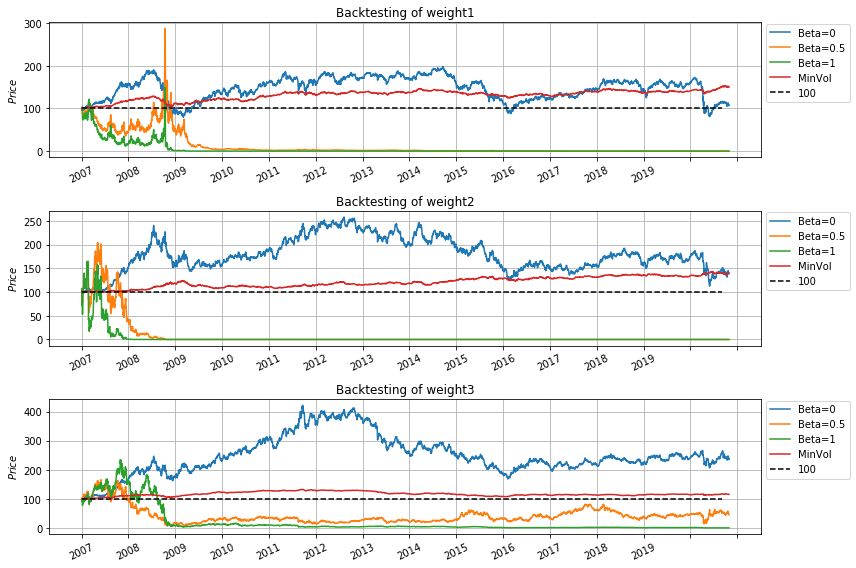

In [19]:
fig, axes = plt.subplots(figsize=(12,8),nrows=3,ncols=1) 
ax1 = S1.plot(ax=axes[0]) 
ax1.plot([0,3420],[100,100],'k--',label='100') 
ax1.set_ylabel(r'$Price$')
ax1.set_title('Backtesting of weight1') 
ax1.set_xticks([0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500]) 
ax1.set_xticklabels(np.arange(2007,2020),rotation=25) 
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.7))

ax2 = S2.plot(ax=axes[1]) 
ax2.plot([0,3420],[100,100],'k--',label='100') 
ax2.set_ylabel(r'$Price$')
ax2.set_title('Backtesting of weight2') 
ax2.set_xticks([0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500]) 
ax2.set_xticklabels(np.arange(2007,2020),rotation=25) 
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.7)) 

ax3 = S3.plot(ax=axes[2]) 
ax3.plot([0,3420],[100,100],'k--',label='100') 
ax3.set_ylabel(r'$Price$')
ax3.set_title('Backtesting of weight3') 
ax3.set_xticks([0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500]) 
ax3.set_xticklabels(np.arange(2007,2020),rotation=25) 
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.7)) 
    
ax1.grid()
ax2.grid()
ax3.grid()
fig.tight_layout()
plt.show()

In [20]:
Ret1

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,ILF,EPP,FEZ,XBI
1,-1.499409,2.640855,-2.528891,4.740979,0.530528,0.138006,-0.399689,-10.172075,-2.953280,-4.250474,-0.137249,5.086421
2,-1.603904,-6.446007,-6.001636,-1.191573,-1.994079,-0.045983,-3.202559,2.321178,-6.527287,-3.369874,-4.348228,-0.107212
3,0.345930,1.430631,1.288023,0.171052,1.156271,0.137956,0.709648,-1.777128,3.022900,1.975469,0.139755,0.804379
4,-0.403022,1.600270,1.529427,1.253404,-0.212471,-0.022983,3.740405,-1.000223,-6.395942,0.694169,-0.605219,0.694885
5,-0.941854,-3.710248,-1.068194,2.947849,0.832895,-0.045970,19.920318,-10.253693,2.337592,-2.219244,-2.706730,2.132194
...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.422366,0.000000,2.300070,4.130265,1.382904,-0.091118,0.000000,1.611888,5.923706,3.143033,0.834787,1.506515
197,0.017559,-2.926998,1.843421,-1.914813,-2.110931,0.091151,-0.946975,7.382810,-4.069910,-4.727206,-1.624405,0.956753
198,-0.702681,-4.529621,-0.066531,-1.176581,-1.983736,0.159453,3.715868,4.135696,-4.284316,-5.892253,-2.073698,-1.035977
199,0.669420,0.354853,-2.063374,3.215436,0.764081,0.068291,1.873291,-1.306383,4.059765,3.790141,2.855087,1.289937


In [21]:
Ret2

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,ILF,EPP,FEZ,XBI
1,0.678968,0.944826,2.091678,1.041455,-0.120734,0.136582,-3.325643,-0.318588,2.333504,0.586256,0.839325,0.842589
2,0.135431,-6.400605,-1.285504,-10.964033,-6.126610,0.022757,2.784299,-3.381412,-8.131961,-7.034718,-5.138612,-2.561298
3,-0.981324,-1.545594,-1.057208,-1.188034,-0.212291,-0.068247,-1.014488,-5.853051,-2.618245,2.841873,1.952170,1.230269
4,0.237829,-0.583199,5.927811,-6.487441,-4.037111,0.068266,1.018622,1.854297,0.745496,-4.214887,-2.623089,1.266469
5,-0.695771,5.455957,-0.662583,5.328218,2.627585,0.068247,14.130440,-2.662364,5.579739,4.858775,1.549760,1.176062
...,...,...,...,...,...,...,...,...,...,...,...,...
196,-3.876397,-10.933803,-18.576196,-1.586300,-6.063939,-0.158658,1.526716,-11.135052,-8.717443,-4.144692,-10.444855,-12.492606
197,3.788159,39.554997,-3.695035,30.411889,36.299431,-0.022685,-15.079667,4.812025,65.614615,41.475094,43.836278,33.160090
198,0.919118,-1.334050,0.640319,-10.816968,-3.700049,0.204129,0.201862,-10.143110,-3.289471,-7.394016,-6.605295,-5.736041
199,-2.692310,-26.019296,3.375914,-22.389171,-24.611923,-0.135975,7.462684,-16.530829,-48.666668,-27.006438,-28.577290,-17.283497


In [22]:
Ret3

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,ILF,EPP,FEZ,XBI
1,-5.122676,-6.230524,-5.073640,-0.080569,-0.295828,0.000000,-9.023937,11.717640,8.672140,-1.977393,-6.369878,3.409526
2,-1.031227,-2.396170,1.923514,2.498384,1.669367,0.045304,0.764233,-0.335116,10.454216,5.315105,2.129854,-2.409111
3,2.052516,-2.419359,-6.989303,-7.101814,-7.489042,-0.158517,1.904769,-26.711406,-17.214531,-7.249059,-3.422671,-3.809436
4,1.834055,3.528776,5.166160,2.628118,1.020191,0.022662,-16.824203,-0.525997,2.322557,0.765696,2.510338,1.444833
5,-5.371053,-4.282651,-1.598392,-5.607937,-5.354802,0.000000,0.000000,-6.250014,-2.577326,-10.782453,-11.184229,-5.607048
...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.829506,-1.253766,1.689853,0.058739,-0.510775,0.068061,3.934740,3.051227,0.054788,-0.360759,-1.358693,-1.914408
197,1.501652,2.772169,-0.191833,3.405343,4.303924,0.022687,-3.495833,3.014411,7.940837,7.707122,8.374910,3.066882
198,0.251592,-1.246266,-3.167594,-0.579231,0.914833,-0.045369,3.737058,8.417503,0.849256,1.109827,0.287352,5.668500
199,-0.686957,-4.509002,0.777755,-1.625654,-1.868562,-0.045360,-2.171446,3.382617,-2.274632,-3.489197,-5.855341,-2.245810


In [23]:
pd.DataFrame(Sig1,index = name_list,columns = name_list)

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,ILF,EPP,FEZ,XBI
FXE,0.820242,0.314153,0.492075,0.425616,0.419475,0.001395,-0.605056,0.395395,0.935032,0.734681,0.571511,0.185453
EWJ,0.314153,4.675093,1.713107,1.628637,1.635762,0.003569,-1.614826,1.921199,3.875532,2.970519,2.194355,0.898895
GLD,0.492075,1.713107,6.112127,2.487064,2.495758,0.005000,-2.630944,2.859615,5.863989,4.515403,3.349827,1.339106
QQQ,0.425616,1.628637,2.487064,6.138711,2.781972,0.009304,-1.326943,3.884469,7.009603,5.199505,3.712961,1.808245
SPY,0.419475,1.635762,2.495758,2.781972,4.975794,0.007398,-1.189437,4.062910,7.190538,5.329516,3.761226,1.892617
SHV,0.001395,0.003569,0.005000,0.009304,0.007398,0.038509,-0.004160,0.004467,0.017466,0.010926,0.012322,0.001762
DBA,-0.605056,-1.614826,-2.630944,-1.326943,-1.189437,-0.004160,11.585870,0.894424,-1.362394,-1.559808,-1.745673,0.397926
USO,0.395395,1.921199,2.859615,3.884469,4.062910,0.004467,0.894424,17.068501,11.114961,8.011086,5.278540,3.325537
ILF,0.935032,3.875532,5.863989,7.009603,7.190538,0.017466,-1.362394,11.114961,25.529657,13.743259,9.492246,5.172904
EPP,0.734681,2.970519,4.515403,5.199505,5.329516,0.010926,-1.559808,8.011086,13.743259,14.853334,7.037655,3.732032


In [24]:
Port_Ret1

,Beta=0,Beta=0.5,Beta=1,MinVol
1,-4.858863,-4.390113,-7.358791,-0.344559
2,-1.901691,9.710096,15.881871,-1.268143
3,0.941601,-5.486672,-9.232417,0.367712
4,-1.502140,4.392993,7.155230,0.551697
5,-3.609697,-39.114342,-63.195415,1.956635
...,...,...,...,...
196,3.859228,-10.735517,-17.223706,0.954471
197,1.488714,25.326439,40.874993,0.443369
198,-1.046089,10.676524,17.014508,0.295440
199,1.164638,-19.521824,-31.827420,0.541690


In [25]:
all_weight1

,Beta=0,Beta=0.5,Beta=1,MinVol
FXE,-0.007674,1.116433,1.807788,0.329186
EWJ,-0.080685,1.116433,1.807788,-0.036357
GLD,0.217183,1.116433,1.807788,0.121013
QQQ,0.028330,-1.116433,-1.807788,0.093441
SPY,-0.071500,-1.116433,-1.807787,-0.069317
SHV,-0.113251,1.116433,-0.489828,0.332219
DBA,-0.044190,-1.116433,-1.807788,0.103613
USO,0.361117,1.116433,1.807788,0.026268
ILF,0.262777,-1.116433,-1.807788,0.005455
EPP,0.275891,-1.099003,-1.795327,0.023830


In [26]:
Port_Ret2

,Beta=0,Beta=0.5,Beta=1,MinVol
1,1.139924,18.238695,37.050784,0.467560
2,2.354382,-31.167385,-56.841779,0.894033
3,-3.081428,19.252247,39.196457,-0.760701
4,7.682176,11.091015,26.581985,1.569100
5,-4.240432,1.012291,-0.636070,-0.886814
...,...,...,...,...
196,-14.984432,-90.710819,-177.461776,-1.284009
197,-17.653884,343.475614,658.324244,-1.557725
198,-1.454918,-4.434309,-5.196220,1.463923
199,9.107563,-188.601255,-356.700132,1.449935


In [27]:
all_weight2

,Beta=0,Beta=0.5,Beta=1,MinVol
FXE,0.225230,-1.923220,-3.893891,0.115872
EWJ,-0.142118,1.923220,3.893890,0.039063
GLD,0.552200,1.923220,3.893890,-0.001630
QQQ,-0.130219,-1.923220,-3.893891,-0.030181
SPY,-0.213073,-0.924126,-2.893145,-0.035639
SHV,0.226342,-1.923220,-3.893891,1.000000
DBA,-0.031304,-1.923220,-3.893890,-0.044931
USO,0.426914,-1.923220,-3.893891,-0.001785
ILF,-0.001048,1.923218,3.893889,0.068795
EPP,-0.019059,1.923220,3.893888,-0.105794


In [28]:
Port_Ret3

,Beta=0,Beta=0.5,Beta=1,MinVol
1,5.164430,-7.477686,17.421998,0.635512
2,3.265322,12.769819,9.663184,2.045512
3,-12.548481,-8.234607,-42.608289,-2.202038
4,2.742191,23.612630,23.508672,-0.101889
5,-0.060793,-17.138845,-22.598434,-0.065885
...,...,...,...,...
196,2.548478,-9.830377,-6.674491,0.591882
197,-0.811513,22.912437,25.931305,0.451572
198,1.600591,-7.528107,6.445078,-0.378552
199,3.784246,-16.473121,-9.574219,0.239248


In [29]:
all_weight3

,Beta=0,Beta=0.5,Beta=1,MinVol
FXE,0.181603,-0.999618,-1.000000,0.010733
EWJ,-0.306543,1.000000,1.000000,-0.096497
GLD,0.772258,1.000000,0.376534,0.088521
QQQ,-0.017187,-0.999999,-0.999999,0.076336
SPY,-0.295956,-0.311181,-0.999995,-0.066215
SHV,0.142937,-0.967081,-1.000000,0.881463
DBA,0.004199,-0.722122,-1.000000,0.030340
USO,0.197235,-1.000000,0.623463,-0.011994
ILF,0.235210,1.000000,1.000000,0.105615
EPP,0.221316,1.000000,1.000000,0.076447


In [30]:
Table1

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,ILF,EPP,FEZ,XBI,Opt_Port,SPY
Geo Daily Mean Return,0.105350,-0.002644,0.248990,0.272818,0.104468,0.013155,0.202581,0.402892,0.523849,0.400853,0.182749,0.338805,0.166627,0.104468
Daily Min Return,-2.118334,-6.446007,-9.875165,-10.268663,-9.764411,-1.071692,-10.147605,-10.253693,-19.868474,-14.626076,-11.849608,-9.980058,-2.465430,-9.764411
Max Drawdown,1.995541,2.079895,2.264601,2.432708,2.326706,4.359003,1.509410,1.771730,2.219231,2.425971,2.074983,2.334511,1.981708,2.326706
Volatility,0.905594,2.162349,2.472070,2.477513,2.230589,0.196205,3.403777,4.131200,5.052567,3.853878,2.917695,2.737981,0.766164,2.230589
Sharpe Ratio,0.098483,-0.005148,0.098454,0.107879,0.043314,-0.023256,0.061029,0.101432,0.110262,0.107103,0.062354,0.122692,0.195780,0.043314
Skewness,-0.049336,-0.033544,-0.492383,-0.557370,-0.759570,-3.565555,0.513382,-0.065508,-0.478230,-0.612765,-0.324569,-0.177258,-0.351054,-0.759570
Kurtosis,-0.297058,0.401473,1.695972,1.328072,2.647229,14.213192,5.521043,0.052309,1.561388,1.627300,2.052645,1.008964,0.356642,2.647229
VaR,-1.459327,-4.006977,-3.984067,-4.620341,-3.821527,-0.341254,-5.067558,-6.812387,-8.587442,-6.789470,-4.653478,-4.439265,-1.234751,-3.821527
CVaR,-1.787782,-4.789674,-5.988426,-5.701501,-5.960438,-0.804090,-7.676834,-8.400894,-12.325309,-9.507402,-7.051163,-6.041961,-1.575789,-5.960438


In [31]:
get_Table(Strategy1)

,Beta=0,Beta=0.5,Beta=1,MinVol,S&P 500
Geo Daily Mean Return,0.525965,-1.091319,-2.190820,0.166627,0.073729
Daily Min Return,-13.593009,-41.778706,-67.967064,-2.465430,-7.412407
Max Drawdown,2.413005,1.932511,1.936625,1.981708,2.015120
Volatility,3.336601,13.645401,22.176521,0.766164,2.647928
Sharpe Ratio,0.158960,-0.054064,-0.055046,0.195780,0.026404
Skewness,-0.527875,0.158330,0.156355,-0.351054,-0.331472
Kurtosis,1.250934,1.023610,1.008917,0.356642,0.909711
VaR,-5.377754,-22.622837,-37.469820,-1.234751,-5.092071
CVaR,-7.532463,-31.203540,-50.713623,-1.575789,-6.471271


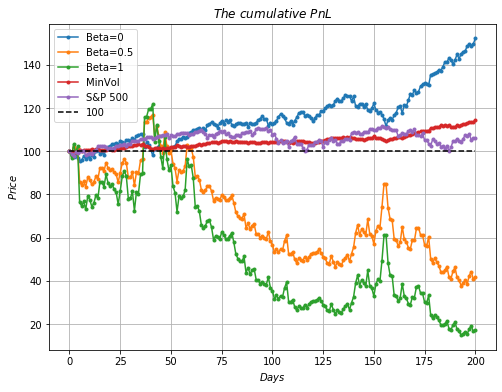

In [32]:
plot_PnLs(Table_Ret1,200)

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


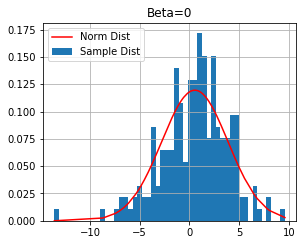

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


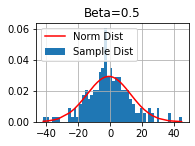

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


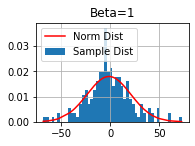

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


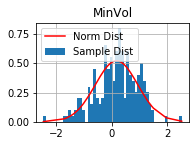

In [33]:
DR_Dist(Port_Ret1)

In [34]:
Table2

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,ILF,EPP,FEZ,XBI,Opt_Port,SPY
Geo Daily Mean Return,-0.112603,-0.500673,-0.084849,-0.557330,-0.543665,0.005452,-0.350472,-0.349047,-0.807190,-0.754860,-0.769306,-0.173432,0.154374,-0.543665
Daily Min Return,-6.429315,-26.019296,-18.576196,-22.389171,-24.611923,-0.904981,-21.514936,-26.447056,-48.666668,-28.054528,-28.577290,-17.283497,-3.150900,-24.611923
Max Drawdown,2.037832,1.657800,1.658116,1.736198,1.678025,2.138729,2.512770,2.337796,1.741705,1.676419,1.651910,1.521214,1.893072,1.678025
Volatility,1.846713,5.789925,4.873951,5.463495,5.307146,0.170231,5.843203,6.393997,9.758582,6.871601,6.308598,5.332841,0.963818,5.307146
Sharpe Ratio,-0.066933,-0.078144,-0.011408,-0.094398,-0.095296,-0.072170,-0.051305,-0.044577,-0.065228,-0.098759,-0.112323,-0.025360,0.143622,-0.095296
Skewness,-0.042952,1.035079,0.505229,0.296680,0.806175,-1.144777,-0.374796,-0.196530,0.745335,0.334774,0.992047,0.940474,0.249618,0.806175
Kurtosis,0.883315,12.911341,5.751784,6.299916,13.736068,8.402613,1.072220,1.193474,13.803332,9.033500,14.774763,7.571912,1.534995,13.736068
VaR,-3.173846,-8.920168,-7.679605,-9.121059,-7.526585,-0.385903,-11.663287,-10.415460,-15.065899,-12.306129,-10.676745,-8.494605,-1.311541,-7.526585
CVaR,-4.179752,-13.638119,-10.947552,-14.005873,-13.974561,-0.540975,-14.882317,-14.463845,-25.741065,-18.598850,-16.588281,-12.444031,-1.903866,-13.974561


In [35]:
get_Table(Strategy2)

,Beta=0,Beta=0.5,Beta=1,MinVol,S&P 500
Geo Daily Mean Return,0.257084,-6.464159,nan,0.154374,-0.559698
Daily Min Return,-17.653884,-188.601255,-356.700132,-3.150900,-22.587445
Max Drawdown,1.782871,1.549096,1.541830,1.893072,1.780220
Volatility,5.420333,45.476021,87.487915,0.963818,6.995403
Sharpe Ratio,0.054886,-0.050225,-0.046949,0.143622,-0.068625
Skewness,0.292770,1.734880,1.739422,0.249618,0.190941
Kurtosis,2.209376,17.305906,16.927985,1.534995,3.357388
VaR,-8.102512,-73.789775,-141.707242,-1.311541,-12.973476
CVaR,-11.737673,-100.588299,-191.010602,-1.903866,-17.867855


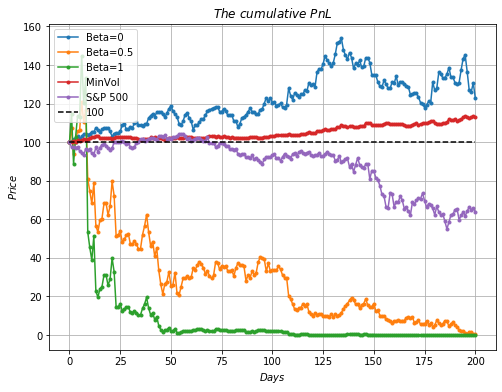

In [36]:
plot_PnLs(Table_Ret2,200)

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


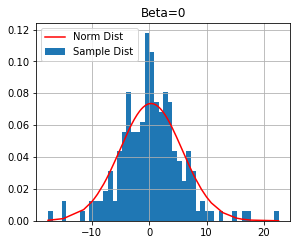

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


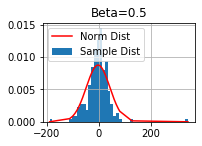

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


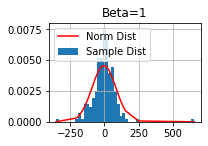

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


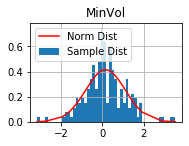

In [37]:
DR_Dist(Port_Ret2)

In [38]:
Table3

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,ILF,EPP,FEZ,XBI,Opt_Port,SPY
Geo Daily Mean Return,0.093058,0.042121,0.237090,0.414240,0.208087,-0.001926,-0.011099,0.168198,0.711472,0.606641,0.270962,-0.063309,0.149653,0.208087
Daily Min Return,-7.687385,-10.783204,-9.413716,-12.406535,-13.196561,-0.272115,-16.824203,-26.711406,-18.704575,-18.619234,-21.416664,-13.249457,-2.202038,-13.196561
Max Drawdown,1.837507,1.551381,1.806291,1.803382,1.734888,2.331725,2.556632,2.221986,2.004759,1.864739,2.059582,1.657517,2.076521,1.734888
Volatility,2.118370,4.354482,3.277630,4.272672,4.524641,0.072716,4.265590,8.051465,7.036924,6.175081,6.383292,4.613803,0.625053,4.524641
Sharpe Ratio,0.039744,0.014214,0.073417,0.101270,0.051051,-0.271067,0.001746,0.034781,0.112602,0.107636,0.052431,-0.008427,0.212198,0.051051
Skewness,-0.049684,0.412089,0.117541,0.083556,0.062683,-0.622952,-0.297116,-0.205362,-0.193510,-0.054143,-0.330875,0.337159,-0.011739,0.062683
Kurtosis,1.769237,1.984675,0.561331,1.149262,1.647481,2.079917,0.784925,0.865252,0.603663,0.733221,1.114589,2.321142,1.074867,1.647481
VaR,-3.496894,-6.952856,-5.059145,-7.396450,-7.863615,-0.158658,-8.109727,-12.506750,-11.456125,-10.470675,-12.114842,-7.164035,-0.726945,-7.863615
CVaR,-4.728233,-9.172984,-6.879332,-8.777740,-10.333529,-0.196509,-9.893531,-18.947993,-16.008177,-13.229310,-15.333638,-10.243677,-1.259395,-10.333529


In [39]:
get_Table(Strategy3)

,Beta=0,Beta=0.5,Beta=1,MinVol,S&P 500
Geo Daily Mean Return,0.312104,0.695798,0.527964,0.149653,0.580122
Daily Min Return,-13.643067,-40.375296,-70.998902,-2.202038,-10.697436
Max Drawdown,1.979463,1.685289,2.110468,2.076521,1.604738
Volatility,3.713653,16.225873,20.240889,0.625053,3.908179
Sharpe Ratio,0.086664,0.073973,0.066416,0.212198,0.151613
Skewness,-0.414506,0.102440,-0.322451,-0.011739,0.435928
Kurtosis,1.792463,0.548297,0.855883,1.074867,2.658861
VaR,-5.522091,-26.078072,-37.590465,-0.726945,-5.963635
CVaR,-8.859254,-32.954177,-46.647954,-1.259395,-7.912937


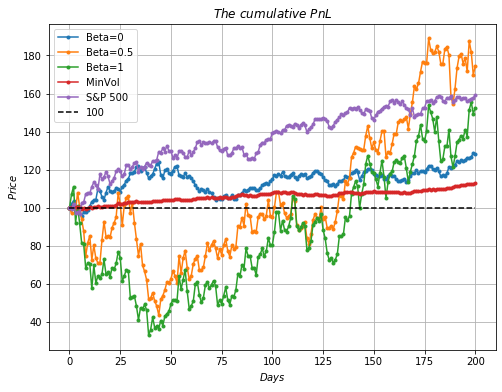

In [40]:
plot_PnLs(Table_Ret3,200)

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


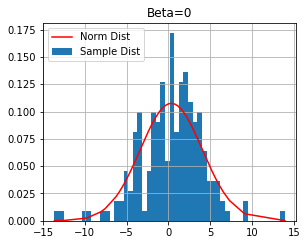

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


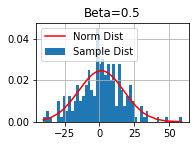

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


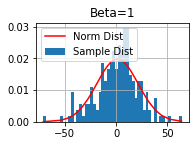

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


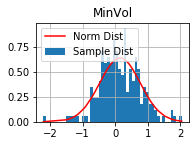

In [41]:
DR_Dist(Port_Ret3)

In [42]:
Table_Ret2s

,Beta=0,Beta=0.5,Beta=1,MinVol,S&P 500
1,-2.120942,4.311076,-0.553888,0.199957,-6.772426
2,16.525428,-8.216215,10.361230,0.297893,0.133388
3,-1.881530,-2.167700,-7.441237,-0.288000,-0.861907
4,15.853467,12.513364,16.529829,0.706239,1.309582
5,9.489858,-0.066867,3.087311,0.264012,-5.503484
6,5.675849,6.532911,3.900040,0.663654,-2.102590
7,11.223273,-11.140127,-1.339831,0.323263,-3.865870
8,-8.985822,9.622609,5.478480,-0.038380,9.282461
9,17.981895,-28.278551,0.953530,0.045017,-2.248893
10,-1.448635,-17.378844,-23.840251,-0.470645,1.281730


In [43]:
Table_Ret2m

,Beta=0,Beta=0.5,Beta=1,MinVol,S&P 500
1,-0.727873,-1.029231,-4.909022,0.149066,-6.772426
2,8.158852,2.578401,31.203248,0.000292,0.133388
3,-8.684034,7.348311,6.360599,-1.011951,-0.861907
4,13.727940,-4.074651,4.889605,0.921996,1.309582
5,-2.694118,13.993786,4.212653,0.974522,-5.503484
...,...,...,...,...,...
116,8.580840,-1.174197,2.970751,0.171106,-0.728916
117,-7.382088,9.920362,14.052783,-0.447207,1.380450
118,20.603802,-4.278842,20.437161,1.022509,1.018983
119,2.310372,-5.866292,-13.865695,0.037480,-3.774452


In [44]:
Table_Ret2l

,Beta=0,Beta=0.5,Beta=1,MinVol,S&P 500
1,1.139924,18.238695,37.050784,0.467560,-6.772426
2,2.354382,-31.167385,-56.841779,0.894033,0.133388
3,-3.081428,19.252247,39.196457,-0.760701,-0.861907
4,7.682176,11.091015,26.581985,1.569100,1.309582
5,-4.240432,1.012291,-0.636070,-0.886814,-5.503484
...,...,...,...,...,...
196,-14.984432,-90.710819,-177.461776,-1.284009,9.124854
197,-17.653884,343.475614,658.324244,-1.557725,9.596837
198,-1.454918,-4.434309,-5.196220,1.463923,-5.779386
199,9.107563,-188.601255,-356.700132,1.449935,2.973547


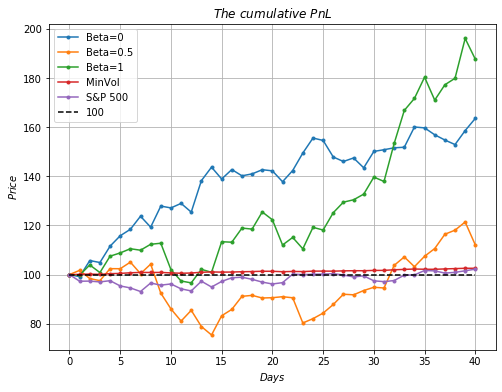

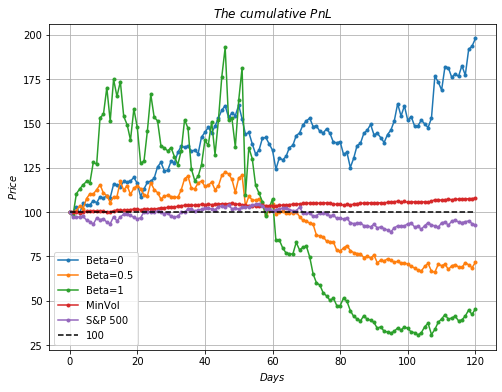

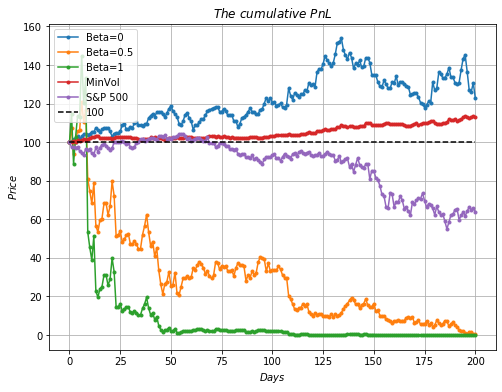

In [45]:
# compair the image of short term, middle term and long term
plot_PnLs(Table_Ret2s,40)
plot_PnLs(Table_Ret2m,120)
plot_PnLs(Table_Ret2l,200)

In [46]:
Ret1.to_csv('Ret1.csv', index = True)
Ret2.to_csv('Ret2.csv', index = True)
Ret3.to_csv('Ret3.csv', index = True)

pd.DataFrame(Sig1,index = name_list,columns = name_list).to_csv('Cross_Sectional.csv', index = True)

Port_Ret1.to_csv('Port_Ret1.csv', index = True)
all_weight1.to_csv('all_weight1.csv', index = True)
Port_Ret2.to_csv('Port_Ret2.csv', index = True)
all_weight2.to_csv('all_weight2.csv', index = True)
Port_Ret3.to_csv('Port_Ret3.csv', index = True)
all_weight3.to_csv('all_weight3.csv', index = True)

Table1.to_csv('Table1.csv', index = True)
get_Table(Strategy1).to_csv('Strategy1.csv', index = True)
Table2.to_csv('Table2.csv', index = True)
get_Table(Strategy2).to_csv('Strategy2.csv', index = True)
Table3.to_csv('Table3.csv', index = True)
get_Table(Strategy3).to_csv('Strategy3.csv', index = True)